In [1]:
import os
os.chdir('/local/home/mhoerold/entrack')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
import nibabel as nib
import copy
import tensorflow as tf

from src.baum_vagan.vagan.model_wrapper import VAGanWrapper
from src.baum_vagan.utils import ncc
from src.data.streaming.vagan_streaming import MRIImagePair, AgeFixedDeltaStream
from src.baum_vagan.utils import map_image_to_intensity_range
from src.data.streaming.mri_streaming import MRISingleStream

In [3]:
def load_wrapper(smt_label):
    config_path = os.path.join("data", smt_label, "config.yaml")
    model_dir = os.path.join("data", smt_label, "logdir")
    with open(config_path, 'r') as f:
        model_config = yaml.load(f)
    wrapper = VAGanWrapper(**model_config)
    wrapper.vagan.load_weights(model_dir)
    
    return wrapper

In [4]:
hc_wrapper = load_wrapper('20180823-185855')
ad_wrapper = load_wrapper('20180823-185845')

Instructions for updating:
Use the retry module or similar alternatives.


2018-10-15 09:36:20,578 From /local/home/mhoerold/miniconda3/envs/thesis/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:198: retry (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Use the retry module or similar alternatives.
/local/home/mhoerold/entrack/src/data/streaming/base.py:1156: UserWarning: !!! 4076 IDs WERE NOT EXTRACTED !!!
  .format(discarded))


ADNI_AIBL has 20092 files
4 images blacklisted
332 files found but not specified meta csv
Number of files: 19760
Number of files missing: 0
Splitting 2059 images
>>>>>> k-fold split
###### Folds info #######
>>>>>>>>>>>>>>>>
>>>> Distinct patients: 96
>>>> Distinct images: 389
>>>> Age stats, mean=76.18766021728516, std=6.584491729736328
>>>> Age diffences stats, mean=1.788395881652832, std=1.6366958618164062
>>>> healthy count: 389 (1.0)
>>>> healthy subject count: 96
>>>> healthy age: 76.55069732666016 6.61745023727417
>>>> Gender 0: 183 (0.4704370179948586)
>>>> Gender 1: 206 (0.5295629820051414)
>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>
>>>> Distinct patients: 96
>>>> Distinct images: 422
>>>> Age stats, mean=75.25118255615234, std=6.457916259765625
>>>> Age diffences stats, mean=1.944785237312317, std=1.7835359573364258
>>>> healthy count: 422 (1.0)
>>>> healthy subject count: 96
>>>> healthy age: 75.650634765625 6.511063575744629
>>>> Gender 0: 232 (0.5497630331753555)
>>>> Gender 1: 190

2018-10-15 09:36:29,622 From /local/home/mhoerold/entrack/src/baum_vagan/tfwrapper/layers.py:69: calling reduce_mean (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


INFO:tensorflow:Restoring parameters from data/20180823-185855/logdir/model.ckpt-19990


2018-10-15 09:36:37,986 Restoring parameters from data/20180823-185855/logdir/model.ckpt-19990


ADNI_AIBL has 20092 files
4 images blacklisted
332 files found but not specified meta csv
Number of files: 19760
Number of files missing: 0
Splitting 570 images
>>>>>> k-fold split
###### Folds info #######
>>>>>>>>>>>>>>>>
>>>> Distinct patients: 40
>>>> Distinct images: 104
>>>> Age stats, mean=75.88461303710938, std=7.867053508758545
>>>> Age diffences stats, mean=1.25, std=0.6846532225608826
>>>> health_ad count: 104 (1.0)
>>>> health_ad subject count: 40
>>>> health_ad age: 76.38127899169922 7.901100158691406
>>>> Gender 0: 51 (0.49038461538461536)
>>>> Gender 1: 53 (0.5096153846153846)
>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>
>>>> Distinct patients: 40
>>>> Distinct images: 110
>>>> Age stats, mean=75.29090881347656, std=8.165721893310547
>>>> Age diffences stats, mean=1.2571429014205933, std=0.7306693196296692
>>>> health_ad count: 110 (1.0)
>>>> health_ad subject count: 40
>>>> health_ad age: 75.75227355957031 8.19815731048584
>>>> Gender 0: 57 (0.5181818181818182)
>>>> Gender 1: 53 (

2018-10-15 09:36:53,794 Restoring parameters from data/20180823-185845/logdir/model.ckpt-19990


In [5]:
test_stream = lambda bs: ad_wrapper.data.testAD.next_batch(bs)[0]

In [6]:
dump_dir = os.path.join('notebooks/vagan_generated/hc_vs_ad')
if not os.path.exists(dump_dir):
    os.makedirs(dump_dir)

## Find train and validation patients

In [7]:
train_val_pairs = ad_wrapper.data.train_pairs + ad_wrapper.data.val_pairs + hc_wrapper.data.train_pairs + hc_wrapper.data.val_pairs
train_patient_ids = set()
for pair in train_val_pairs:
    patient_id = hc_wrapper.data.get_patient_id(pair.fid1)
    train_patient_ids.add(patient_id)

## Find all test patients

In [9]:
single_config = copy.deepcopy(ad_wrapper.data.config)
single_config["use_diagnoses"] = ['healthy', 'health_ad']
single_stream = MRISingleStream(single_config)

/local/home/mhoerold/entrack/src/data/streaming/base.py:1156: UserWarning: !!! 4076 IDs WERE NOT EXTRACTED !!!
  .format(discarded))


ADNI_AIBL has 20092 files
4 images blacklisted
332 files found but not specified meta csv
Number of files: 19760
Number of files missing: 0
Selected 11090 out of 19756
Splitting 11090 images
>>>>>> k-fold split
###### Folds info #######
>>>>>>>>>>>>>>>>
>>>> Distinct patients: 355
>>>> Distinct images: 2115
>>>> Age stats, mean=75.38156127929688, std=6.447206020355225
>>>> Age diffences stats, mean=0.6045454740524292, std=1.3208905458450317
>>>> health_ad count: 928 (0.43877068557919624)
>>>> health_ad subject count: 155
>>>> health_ad age: 76.09996795654297 6.865014553070068
>>>> healthy count: 1187 (0.5612293144208038)
>>>> healthy subject count: 204
>>>> healthy age: 75.60139465332031 6.131402492523193
diag,image_count,subject_count,age_mean,age_std
health_ad,928,155,76.09997,6.8650146
healthy,1187,204,75.601395,6.1314025

>>>> Gender 0: 1180 (0.557919621749409)
>>>> Gender 1: 935 (0.44208037825059104)
>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>
>>>> Distinct patients: 355
>>>> Distinct image

In [10]:
all_patient_ids = set()
for fid in single_stream.all_file_ids:
    all_patient_ids.add(single_stream.get_patient_id(fid))
    
hc_test_fids = set()
ad_test_fids = set()
for fid in single_stream.all_file_ids:
    pid = single_stream.get_patient_id(fid)
    if pid not in train_patient_ids:
        diag = single_stream.get_diagnose(fid)
        if diag == "healthy":
            hc_test_fids.add(fid)
        elif diag == "health_ad":
            ad_test_fids.add(fid)
            
hc_test_fids = list(hc_test_fids)
ad_test_fids = list(ad_test_fids)
np.random.seed(11)
np.random.shuffle(hc_test_fids)
np.random.shuffle(ad_test_fids)

## Make predictions

051_S_5293


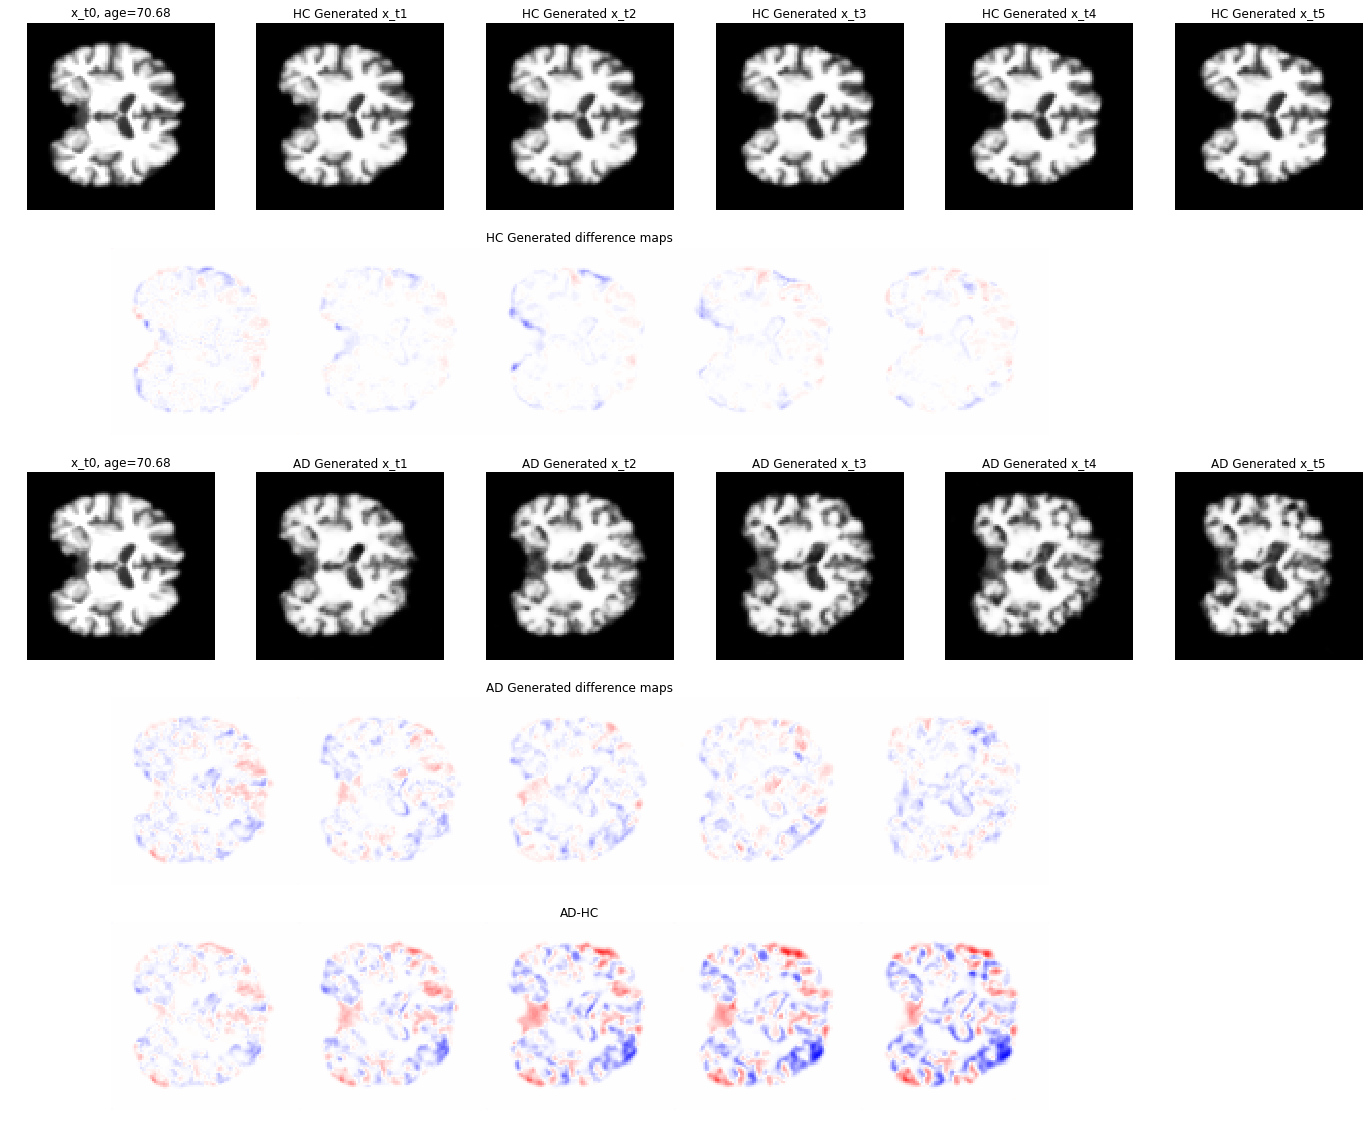

In [13]:
def iterate_model(model, img, n_steps):
    images = []
    masks = []
    # placeholder needs a second channel not used by generator
    delta_channel = img * 0 + 1.0
    img = np.concatenate((img, delta_channel, img), axis=-1)
    img = np.array([img])  # make a batch of size 1
    for _ in range(n_steps):
        M = model.predict_mask(img)
        masks.append(np.squeeze(M))
        img += M
        img[:, :, :, 1] = delta_channel[:, :, 0]
        images.append(np.copy(np.squeeze(img[:, :, :, 0])))
        # placeholder needs a second channel not used by generator
        # img = np.concatenate((img, img), axis=-1)
        
    return images, masks

def compare_hc_ad_images_and_masks(x_t0, t0, hc_images, hc_masks, ad_images, ad_masks):
    # plot predictions
    nrows = 5
    ncols = len(hc_images) + 1
    fsize = 4
    plt.figure(figsize=(ncols * fsize, nrows * fsize))
    # plot hc images
    plt.subplot(nrows, ncols, 1)
    plt.imshow(np.squeeze(x_t0), cmap='gray')
    plt.title("x_t0, age={}".format(str(t0)))
    plt.axis('off')

    for i, img in enumerate(hc_images):
        plt.subplot(nrows, ncols, i + 2)
        plt.imshow(np.squeeze(img), cmap='gray')
        plt.title('HC Generated x_t{}'.format(i + 1))
        plt.axis('off')

    # plot masks
    # concatenate differnce maps to plot with same scale
    plt.subplot(nrows, ncols, (ncols + 1, ncols + len(hc_masks)))
    mask_slices = [m for m in hc_masks]
    mask_slices_im = np.hstack(tuple(mask_slices))
    plt.imshow(mask_slices_im, cmap='bwr', vmin=-2, vmax=2)
    plt.title("HC Generated difference maps")
    plt.axis('off')

    # plot ad images
    plt.subplot(nrows, ncols, 2 * ncols + 1)
    plt.imshow(np.squeeze(x_t0), cmap='gray')
    plt.title("x_t0, age={}".format(str(t0)))
    plt.axis('off')

    for i, img in enumerate(ad_images):
        plt.subplot(nrows, ncols, 2 * ncols + i + 2)
        plt.imshow(np.squeeze(img), cmap='gray')
        plt.title('AD Generated x_t{}'.format(i + 1))
        plt.axis('off')

    # plot masks
    # concatenate differnce maps to plot with same scale
    plt.subplot(nrows, ncols, (3 * ncols + 1, 3 * ncols + len(hc_masks)))
    mask_slices = [m for m in ad_masks]
    mask_slices_im = np.hstack(tuple(mask_slices))
    plt.imshow(mask_slices_im, cmap='bwr', vmin=-2, vmax=2)
    plt.title("AD Generated difference maps")
    plt.axis('off')
    
    # HC to AD change
    hc_ad_change = []
    for ad_im, hc_im in zip(ad_images, hc_images):
        change = np.squeeze(ad_im - hc_im)
        hc_ad_change.append(change)
        
    plt.subplot(nrows, ncols, (4 * ncols + 1, 4 * ncols + len(hc_masks)))
    mask_slices = [m for m in hc_ad_change]
    mask_slices_im = np.hstack(tuple(mask_slices))
    plt.imshow(mask_slices_im, cmap='bwr', vmin=-2, vmax=2)
    plt.title("AD-HC")
    plt.axis('off')

    
def plot_iterative_predictions(hc_model, ad_model, fid, delta, real_fids=None):
    # Use normalization of trained model
    # print(pair.get_age_delta())
    # print(pair.streamer.get_image_label(pair.fid1))
    t0 = round(single_stream.get_exact_age(fid), 2)
    
    # get some pair and load image
    some_pair = hc_wrapper.data.train_pairs[0]
    x_t0 = some_pair.load_image(fid)

    n_steps = delta
    hc_images, hc_masks = iterate_model(hc_model, x_t0, n_steps)
    ad_images, ad_masks = iterate_model(ad_model, x_t0, n_steps)

    # dump
    pid = single_stream.get_patient_id(fid)
    print(pid)
    out_path = os.path.join(dump_dir, "{}.npz".format(pid))
    if real_fids is None:
        np.savez(
            out_path,
            hc_fake=[np.squeeze(x_t0)] + hc_images,
            ad_fake=[np.squeeze(x_t0)] + ad_images
        )
    else:
        real_images = [some_pair.load_image(real_id) for real_id in real_fids]
        np.savez(
            out_path,
            real_images=real_images,
            hc_fake=[np.squeeze(x_t0)] + hc_images,
            ad_fake=[np.squeeze(x_t0)] + ad_images,
            real_ages=[single_stream.get_exact_age(real_id) for real_id in real_fids]
        )
    
    compare_hc_ad_images_and_masks(x_t0, t0, hc_images, hc_masks, ad_images, ad_masks)
    
    

plot_iterative_predictions(hc_wrapper.vagan, ad_wrapper.vagan, hc_test_fids[7], 5)

In [14]:
def get_gt_time_series(file_ids, target_delta=1):
    patient_groups = single_stream.make_patient_groups(file_ids)
    patient_to_series = {}

    for g in patient_groups:
        fids = g.file_ids
        
        pid = single_stream.get_patient_id(fids[0])
        patient_to_series[pid] = []
        
        diagnoses = set([])
        for fid in g.file_ids:
            diag = single_stream.get_diagnose(fid)
            diagnoses.add(diag)
        # multiple diagnoses
        #if len(diagnoses) > 1:
         #   continue

        # Determine which images can be used
        # Sort by ascending age
        age_ascending = sorted(
            g.file_ids,
            key=lambda x: single_stream.get_exact_age(x)
        )

        # Filter out same age images
        n = len(age_ascending)

        to_remove = []
        for i in range(1, n):
            prev_age = single_stream.get_exact_age(age_ascending[i - 1])
            cur_age = single_stream.get_exact_age(age_ascending[i])
            if prev_age == cur_age:
                to_remove.append(i)
        to_remove.reverse()
        for i in to_remove:
            del age_ascending[i]
            
        n = len(age_ascending)
        for i in range(n):
            i_fid = age_ascending[i]
            age_i = single_stream.get_exact_age(i_fid)
            series = [i_fid]
            last_age = age_i
            for j in range(i + 1, n):
                j_fid = age_ascending[j]
                age_j = single_stream.get_exact_age(j_fid)
                delta = age_j - last_age
                if target_delta - 0.2 <= delta <= target_delta + 0.2:
                    series.append(j_fid)
                    last_age = age_j
                    
            if len(series) > 1:
                patient_to_series[pid].append(series)
                
    return patient_to_series

In [ ]:
patient_to_series = get_gt_time_series(hc_test_fids)
chosen = []
pid_to_chosen = {}
for pid, series in patient_to_series.items():
    # sort series by length
    ss = sorted(series, key=lambda x: -len(x))
    if len(ss) < 1:
        continue
    p = ", ".join(str(single_stream.get_exact_age(fid)) for fid in ss[0])
    r = ", ".join(str(single_stream.get_image_label(fid)) for fid in ss[0])
    print("{}: {}".format(pid, p))
    print(r)
    chosen.append(ss[0])
    pid_to_chosen[pid] = ss[0]

In [ ]:
cc = pid_to_chosen['128_S_0863']
plot_iterative_predictions(hc_wrapper.vagan, ad_wrapper.vagan, cc[0], 30, cc)

## Very far predictions

In [ ]:
def plot_far_prediction(hc_model, ad_model, fid, deltas=[10, 20, 30]):
    # Use normalization of trained model
    # print(pair.get_age_delta())
    # print(pair.streamer.get_image_label(pair.fid1))
    t0 = round(single_stream.get_exact_age(fid), 2)
    
    # get some pair and load image
    some_pair = hc_wrapper.data.train_pairs[0]
    x_t0 = some_pair.load_image(fid)
    
    def get_slice(img):
        return np.squeeze(img)
    
    def far_preds(x, model):
        cur_inp = x
        preds = []
        for i, delta in enumerate(deltas):
            steps = delta
            if i > 0:
                steps = deltas[i] - deltas[i - 1]

            images, _ = iterate_model(model, cur_inp, steps)
            cur_inp = images[len(images) - 1][:, :]
            cur_inp = np.reshape(cur_inp, tuple(list(cur_inp.shape) + [1]))
            preds.append(np.copy(cur_inp))
            
        diff_maps = []
        diff_maps.append(get_slice(preds[0] - x))
        for i in range(1, len(deltas)):
            diff_map = get_slice(preds[i] - preds[i - 1])
            diff_maps.append(diff_map)
            
        return preds, diff_maps
    
    hc_images, hc_masks = far_preds(x_t0, hc_model)
    ad_images, ad_masks = far_preds(x_t0, ad_model)
    compare_hc_ad_images_and_masks(x_t0, t0, hc_images, hc_masks, ad_images, ad_masks)
    
plot_far_prediction(hc_wrapper.vagan, ad_wrapper.vagan, ad_test_fids[2], deltas=[10, 20, 30])

In [12]:
hc_test_fids

['/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/325794_mni_aligned.nii.gz',
 '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/385178_mni_aligned.nii.gz',
 '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/313319_mni_aligned.nii.gz',
 '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/A472858_mni_aligned.nii.gz',
 '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/46543_mni_aligned.nii.gz',
 '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/194712_mni_aligned.nii.gz',
 '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/A450340_mni_aligned.nii.gz',
 '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/401252_mni_aligned.nii.gz',
 '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/9046_mni_aligned.nii.gz',
 '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/382003_mni_aligned.nii.gz',
 '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/31701_mni_aligned.nii.gz',
 '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/A451159_mni_aligned.nii.gz',
 '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/

In [16]:
with open(os.path.join(dump_dir, "hc_test_fids.txt"), 'w') as f:
    for fid in hc_test_fids:
        f.write('{}\n'.format(fid))

In [18]:
pids = set([single_stream.get_patient_id(fid) for fid in hc_test_fids])
with open(os.path.join(dump_dir, "hc_test_subjects.txt"), 'w') as f:
    for pid in pids:
        f.write('{}\n'.format(pid))

In [19]:
pids = set([single_stream.get_patient_id(fid) for fid in ad_test_fids])
with open(os.path.join(dump_dir, "ad_test_subjects.txt"), 'w') as f:
    for pid in pids:
        f.write('{}\n'.format(pid))